This notebook is meant to compare the different types of matrix decompositions used for training to see which one works best

In [1]:
%matplotlib inline
import time, sys, math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from multiprocessing.pool import ThreadPool as Pool
sys.path.insert(1, '/home/joeadamo/Research/covariance_emulator')
import covariance_emulator as ce
plt.rcParams['figure.facecolor'] = 'white'

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet, CovaPT

In [2]:
N = 43000
N_PROC = 15
N_test = int(N*0.1)
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [3]:
# data and model vectors for chi squared calculations
# TODO: Replace model vector with Yosuke's emulator output
#P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
params_fid = np.array([67.8,0.1190,0.02215,3.094,1.9485,-0.5387])
#Pk_fid = CovaPT.Pk_gg(params_fid, pgg)
Pk_fid = CovaPT.Pk_CLASS_PT(params_fid)
data_vector = np.concatenate([Pk_fid[0], Pk_fid[2]])
    
def chi_squared(C, model_vector):
    P = np.linalg.inv(C)
    x = data_vector - model_vector
    return np.matmul(x.T, np.matmul(P, x))

def signal_to_noise(C):
    P = np.linalg.inv(C)
    return np.matmul(data_vector.T, np.matmul(P, data_vector))

def gaussian_covariance(params, i, offset):
    """
    Loads the model vector and gaussian covariance from file if it exists, otherwise calculates it
    """
    idx = i + offset
    data = np.load(training_dir+"CovA-"+f'{idx:05d}'+".npz")
    np.testing.assert_allclose(params, data["params"])
    try:
        return data["model"], data["C_G"]
    except:
        Pk_galaxy = CovaPT.Pk_CLASS_PT(params)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = data["C_G"]; C_NG = data["C_NG"]
        np.savez(training_dir+"CovA-"+f'{idx:05d}'+".npz", params=data["params"], model=model_vector, C_G=C_G, C_NG=C_NG)
        return model_vector, C_G

We have 3 sets of networks to laod in. 1) networks with no extra data decomposition, 2) networks with Cholesky decomposition, and 3) networks with correlation matrix decomposition

In [4]:
VAE_vanilla     = CovNet.Network_VAE().to(CovNet.try_gpu());      VAE_vanilla.eval()
VAE_cholesky    = CovNet.Network_VAE(True).to(CovNet.try_gpu());  VAE_cholesky.eval()
#VAE_correlation = CovNet.Network_VAE().to(CovNet.try_gpu());      VAE_correlation.eval()
decoder_vanilla     = CovNet.Block_Decoder().to(CovNet.try_gpu());     decoder_vanilla.eval()
decoder_cholesky    = CovNet.Block_Decoder(True).to(CovNet.try_gpu()); decoder_cholesky.eval()
#decoder_correlation = CovNet.Block_Decoder().to(CovNet.try_gpu());     decoder_correlation.eval()
net_vanilla     = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net_cholesky    = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
#net_correlation = CovNet.Network_latent(6, 10).to(CovNet.try_gpu())

VAE_vanilla.load_state_dict(torch.load(data_dir+'Non-Gaussian/network-VAE.params', map_location=CovNet.try_gpu()))
VAE_cholesky.load_state_dict(torch.load(data_dir+'Cholesky-decomp/network-VAE.params', map_location=CovNet.try_gpu()))
#VAE_correlation.load_state_dict(torch.load(data_dir+'Correlation-decomp/network-VAE.params', map_location=CovNet.try_gpu()))
decoder_vanilla.load_state_dict(VAE_vanilla.Decoder.state_dict())
decoder_cholesky.load_state_dict(VAE_cholesky.Decoder.state_dict())
#decoder_correlation.load_state_dict(VAE_correlation.Decoder.state_dict())
net_vanilla.load_state_dict(torch.load(data_dir+"Non-Gaussian/network-latent.params", map_location=CovNet.try_gpu()))
net_cholesky.load_state_dict(torch.load(data_dir+"Cholesky-decomp/network-latent.params", map_location=CovNet.try_gpu()))
#net_correlation.load_state_dict(torch.load(data_dir+"Correlation-decomp/network-latent.params", map_location=CovNet.try_gpu()))

<All keys matched successfully>

In [5]:
# # Load in all the quad networks (there are lots so I split this into its own cell)
# net_q1 = CovNet.Network_VAE_Quad(50, True).to(CovNet.try_gpu()); net_q2 = CovNet.Network_VAE_Quad(50, True).to(CovNet.try_gpu()); net_q3 = CovNet.Network_VAE_Quad(50, False).to(CovNet.try_gpu())
# decoder_q1 = CovNet.Block_Decoder_Quad(50, True).to(CovNet.try_gpu()); decoder_q2 = CovNet.Block_Decoder_Quad(50, True).to(CovNet.try_gpu()); decoder_q3 = CovNet.Block_Decoder_Quad(50, False).to(CovNet.try_gpu())
# net_f1 = CovNet.Network_latent(6, 10).to(CovNet.try_gpu()); net_f2 = CovNet.Network_latent(6, 10).to(CovNet.try_gpu()); net_f3 = CovNet.Network_latent(6, 10).to(CovNet.try_gpu())
# decoder_q1.eval(); decoder_q2.eval(); decoder_q3.eval(); net_f1.eval(); net_f2.eval(); net_f3.eval()

# net_q1.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q1.params", map_location=CovNet.try_gpu()))
# net_q2.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q2.params", map_location=CovNet.try_gpu()))
# net_q3.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q3.params", map_location=CovNet.try_gpu()))          
# decoder_q1.load_state_dict(net_q1.Decoder.state_dict()); decoder_q2.load_state_dict(net_q2.Decoder.state_dict()); decoder_q3.load_state_dict(net_q3.Decoder.state_dict())
# net_f1.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q1.params", map_location=CovNet.try_gpu()))
# net_f2.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q2.params", map_location=CovNet.try_gpu()))
# net_f3.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q3.params", map_location=CovNet.try_gpu()))   

In [6]:
# load the VALIDATION set
# Since this notebook is mostly checking what model works best, we don't want to use the test set to prevent overfitting
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.9), False, False, False)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 4.38 s


Now let's setup the PCA emulator

In [7]:
N_C = 100
C_PCA = np.zeros((N_C, 100, 100))
params_PCA = np.zeros((N_C, 6))
bad_idx = []
for i in tqdm(range(N_C)):
    temp = np.load(PCA_dir+"CovNG-"+f'{i:04d}'+".npz")
    params_PCA[i] = temp["params"]
    C_NG = temp["C"]
    C_G = CovaPT.get_gaussian_covariance(params_PCA[i])
    try:
        L = np.linalg.cholesky(C_G + C_NG)
    except:
        bad_idx.append(i)
        continue
    C_PCA[i] = C_G + C_NG
        
    # if the matrix doesn't match the transpose close enough, manually flip over the diagonal
    try:
        np.testing.assert_allclose(C_PCA[i], C_PCA[i].T, err_msg="covariance must match transpose")
    except AssertionError:
        print("matrix", i, "has high assymetry!")
        L = np.tril(C_PCA[i])
        U = np.tril(C_PCA[i], k=-1).T
        C_PCA[i] = L + U

 27%|███████████▎                              | 27/100 [00:25<01:07,  1.09it/s]

matrix 26 has high assymetry!


 59%|████████████████████████▊                 | 59/100 [00:56<00:37,  1.09it/s]

matrix 58 has high assymetry!


 87%|████████████████████████████████████▌     | 87/100 [01:24<00:13,  1.01s/it]

matrix 86 has high assymetry!


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


In [8]:
params_PCA_2 = np.delete(params_PCA, bad_idx, axis=0)
C_PCA_2 = np.delete(C_PCA, bad_idx, axis=0)
Emu = ce.CovEmu(params_PCA_2, C_PCA_2, NPC_D=20, NPC_L=20)

Now let's calculate the $\chi^2$ errors for each of these networks and the PCA emulator

In [9]:
error_vanilla, error_cholesky, error_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
chisq_true = np.zeros(N_test)
SN_true, SN_diff_vanilla, SN_diff_cholesky, SN_diff_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
Loss_vanilla, Loss_cholesky, Loss_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
for idx in tqdm(range(N_test)):
    C = test_data[idx][1]
    params = test_data[idx][0]

    latent = net_vanilla(params);     C_vanilla = decoder_vanilla(latent.view(1,10)).view(100, 100)
    C_NG = CovNet.symmetric_exp(C_vanilla).to("cpu").detach().numpy()
    latent = net_cholesky(params);    C_cholesky = decoder_cholesky(latent.view(1,10)).view(100, 100)
    C_cholesky = torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))
    C_PCA = Emu.predict(params.to("cpu").detach().numpy())

    model_vector, C_G = gaussian_covariance(params, idx, int(N*0.9))
    C = torch.from_numpy(C.cpu().detach().numpy() + C_G)
    
    Loss_vanilla[idx] = F.l1_loss(torch.from_numpy(C_G + C_NG), C, reduction="sum")
    Loss_cholesky[idx] = F.l1_loss(C_cholesky, C, reduction="sum")
    Loss_PCA[idx] = F.l1_loss(torch.from_numpy(C_PCA).to(CovNet.try_gpu()), C, reduction="sum")
    
    chisq = chi_squared(C.cpu(), model_vector)
    chisq_vanilla = chi_squared(C_G + C_NG, model_vector)
    chisq_cholesky = chi_squared(C_cholesky.to("cpu").detach().numpy(), model_vector)
    chisq_PCA = chi_squared(C_PCA, model_vector)

    SN = signal_to_noise(C.cpu().detach().numpy())
    SN_vanilla = signal_to_noise(C_G + C_NG)
    SN_cholesky = signal_to_noise(C_cholesky.to("cpu").detach().numpy())
    SN_PCA = signal_to_noise(C_PCA)

    chisq_true[idx] = chisq
    error_vanilla[idx] = abs(chisq - chisq_vanilla)
    error_cholesky[idx] = abs(chisq - chisq_cholesky)
    error_PCA[idx] = abs(chisq - chisq_PCA)
    SN_true[idx] = SN
    SN_diff_vanilla[idx] = SN_vanilla - SN
    SN_diff_cholesky[idx] = SN_cholesky - SN
    SN_diff_PCA[idx] = SN_PCA - SN

100%|███████████████████████████████████████| 4300/4300 [05:00<00:00, 14.32it/s]


In [10]:
# # WARNING: this cell takes around 45 minutes to run when doing the chi squared
# from IPython.utils import io
# t1 = time.time()
# error_vanilla, error_cholesky, error_correlation, error_quad, error_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# SN_true, SN_diff_vanilla, SN_diff_cholesky, SN_diff_corr, SN_diff_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# Loss_vanilla, Loss_cholesky, Loss_corr, Loss_quad, Loss_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# for idx in tqdm(range(N_test)):
#     C = test_data[idx][1]
#     params = test_data[idx][0]

#     latent = net_vanilla(params);     C_vanilla = decoder_vanilla(latent.view(1,10)).view(100, 100)
#     C_vanilla = CovNet.symmetric_exp(C_vanilla)
#     #latent = net_cholesky(params);    C_cholesky = decoder_cholesky(latent.view(1,10)).view(100, 100)
#     #C_cholesky = torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))
#     latent = net_correlation(params); C_correlation = decoder_correlation(latent.view(1,10)).view(100, 100)
#     C_correlation = CovNet.corr_to_cov(C_correlation)
#     C_quad = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params).view(100,100)
#     C_quad = CovNet.symmetric_exp(C_quad)
#     C_PCA = Emu.predict(params.to("cpu").detach().numpy())

#     Loss_vanilla[idx] = F.l1_loss(C_vanilla, C, reduction="sum")
#     #Loss_cholesky[idx] = F.l1_loss(C_cholesky, C, reduction="sum")
#     Loss_corr[idx] = F.l1_loss(C_correlation, C, reduction="sum")
#     Loss_quad[idx] = F.l1_loss(C_quad, C, reduction="sum")
#     Loss_PCA[idx] = F.l1_loss(torch.from_numpy(C_PCA).to(CovNet.try_gpu()), C, reduction="sum")

#     try:
#         with io.capture_output() as captured:
#             model_vector = xi_pi(params, gparams)
#         chisq = chi_squared(C.cpu(), model_vector);
#         chisq_vanilla = chi_squared(C_vanilla.to("cpu").detach().numpy(), model_vector);
#         #chisq_cholesky = chi_squared(C_cholesky.to("cpu").detach().numpy(), model_vector);
#         chisq_correlation = chi_squared(C_correlation.to("cpu").detach().numpy(), model_vector);
#         chisq_quad = chi_squared(C_quad.to("cpu").detach().numpy(), model_vector);
#         chisq_PCA = chi_squared(C_PCA, model_vector);
#     except AssertionError:
#         continue

#     SN = signal_to_noise(C.cpu())
#     SN_vanilla = signal_to_noise(C_vanilla.to("cpu").detach().numpy())
#     #SN_cholesky = signal_to_noise(C_cholesky.to("cpu").detach().numpy())
#     SN_correlation = signal_to_noise(C_correlation.to("cpu").detach().numpy())
#     SN_PCA = signal_to_noise(C_PCA)

#     error_vanilla[idx] = abs(chisq - chisq_vanilla)
#     #error_cholesky[idx] = abs(chisq - chisq_cholesky)
#     error_correlation[idx] = abs(chisq - chisq_correlation)
#     error_quad[idx] = abs(chisq - chisq_quad)
#     error_PCA[idx] = abs(chisq - chisq_PCA)
#     SN_true[idx] = SN
#     SN_diff_vanilla[idx] = SN_vanilla - SN
#     #SN_diff_cholesky[idx] = SN_cholesky - SN
#     SN_diff_corr[idx] = SN_correlation - SN
#     SN_diff_PCA[idx] = SN_PCA - SN
    
# # idx = range(15)
# # with Pool(processes=N_PROC) as pool:
# #     error_vanilla = pool.starmap(get_net_info, zip(idx))

# # print(error_vanilla[0], error_vanilla.shape)
# t2 = time.time()
# print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

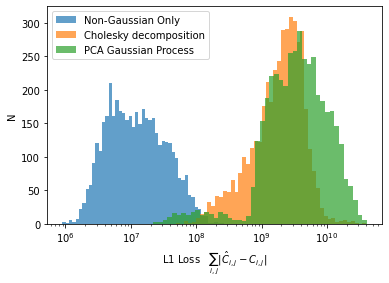

In [11]:
plt.hist(Loss_vanilla, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_vanilla)), np.log10(np.amax(Loss_vanilla)), 50), label="Non-Gaussian Only")
plt.hist(Loss_cholesky, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_cholesky)), np.log10(np.amax(Loss_cholesky)), 50), label="Cholesky decomposition")
#plt.hist(Loss_corr, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_corr)), np.log10(np.amax(Loss_corr)), 50), label="Correlation matrix")
#plt.hist(Loss_quad, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_quad)), np.log10(np.amax(Loss_quad)), 50), label="Seperate quadrants")
plt.hist(Loss_PCA, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_PCA)), np.log10(np.amax(Loss_PCA)), 50), label="PCA Gaussian Process")
plt.xlabel(r"L1 Loss   $\sum_{i,j} |\hat{C}_{i,j} - C_{i,j}|$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()
# compare the different emulators to eachother
    # figure of merit (of countours)
    # sum of principle components <-look up how to do that correctly
    # chi squared difference <- at many different mcmc points (you can use a heatmap)

1839 (42.77)% of matrices have chi squared errors better than 10%!
1357 (31.56)% of matrices have chi squared errors better than 10%!
442 (10.28)% of matrices have chi squared errors better than 10%!


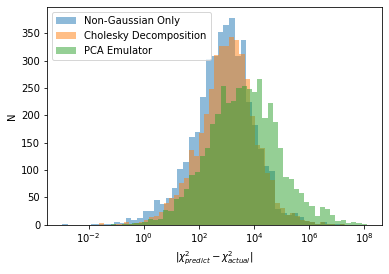

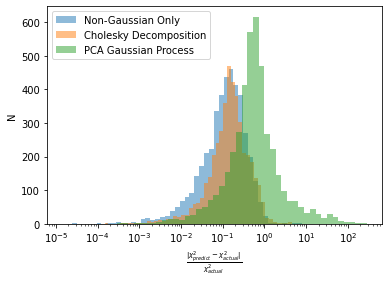

In [12]:
plt.hist(error_vanilla, bins=np.logspace(np.log10(np.amin(error_vanilla)), np.log10(np.amax(error_vanilla)), 50), alpha=0.5, label="Non-Gaussian Only")
plt.hist(error_cholesky, bins=np.logspace(np.log10(np.amin(error_cholesky)), np.log10(np.amax(error_cholesky)), 50), alpha=0.5, label="Cholesky Decomposition")
plt.hist(error_PCA, bins=np.logspace(np.log10(np.amin(error_PCA)), np.log10(np.amax(error_PCA)), 50), alpha=0.5, label="PCA Emulator")
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

rel_err_vanilla = error_vanilla / chisq_true
rel_err_cholesky = error_cholesky / chisq_true
rel_err_PCA = error_PCA / chisq_true

plt.figure()
plt.hist(rel_err_vanilla, bins=np.logspace(np.log10(np.amin(rel_err_vanilla)), np.log10(np.amax(rel_err_vanilla)), 50), alpha=0.5, label="Non-Gaussian Only")
plt.hist(rel_err_cholesky, bins=np.logspace(np.log10(np.amin(rel_err_cholesky)), np.log10(np.amax(rel_err_cholesky)), 50), alpha=0.5, label="Cholesky Decomposition")
plt.hist(rel_err_PCA, bins=np.logspace(np.log10(np.amin(rel_err_PCA)), np.log10(np.amax(rel_err_PCA)), 50), alpha=0.5, label="PCA Gaussian Process")
plt.xlabel(r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

num_Van = len(rel_err_vanilla[(rel_err_vanilla <= 0.1)])
num_Cho = len(rel_err_cholesky[(rel_err_cholesky <= 0.1)])
num_PCA = len(rel_err_PCA[(rel_err_PCA <= 0.1)])
print("{:0d} ({:0.2f})% of matrices have chi squared errors better than 10%!".format(num_Van, 100.*num_Van/N_test))
print("{:0d} ({:0.2f})% of matrices have chi squared errors better than 10%!".format(num_Cho, 100.*num_Cho/N_test))
print("{:0d} ({:0.2f})% of matrices have chi squared errors better than 10%!".format(num_PCA, 100.*num_PCA/N_test))

Let's look at each network on an individual matrix level to see how they're doing

In [ ]:
# Check that matrices with 2 different cosmologies are different
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
C_1 = test_data[idx1][1]; C_2 = test_data[idx2][1]

latent = net_vanilla(params1);     C_vanilla1 = decoder_vanilla(latent.view(1,10)).view(100, 100)
latent = net_vanilla(params2);     C_vanilla2 = decoder_vanilla(latent.view(1,10)).view(100, 100)
C_vanilla1 = CovNet.symmetric_exp(C_vanilla1);  C_vanilla2 = CovNet.symmetric_exp(C_vanilla2)
latent = net_cholesky(params1);    C_cholesky1 = decoder_cholesky(latent.view(1,10)).view(100, 100)
latent = net_cholesky(params2);    C_cholesky2 = decoder_cholesky(latent.view(1,10)).view(100, 100)
C_cholesky1 = torch.matmul(CovNet.symmetric_exp(C_cholesky1), torch.t(CovNet.symmetric_exp(C_cholesky1)))
C_cholesky2 = torch.matmul(CovNet.symmetric_exp(C_cholesky2), torch.t(CovNet.symmetric_exp(C_cholesky2)))
latent = net_correlation(params1); C_correlation1 = decoder_correlation(latent.view(1,10)).view(100, 100)
latent = net_correlation(params2); C_correlation2 = decoder_correlation(latent.view(1,10)).view(100, 100)
C_correlation1 = CovNet.corr_to_cov(C_correlation1); C_correlation2 = CovNet.corr_to_cov(C_correlation2)
C_PCA1 = Emu.predict(params1.to("cpu").detach().numpy())
C_PCA2 = Emu.predict(params2.to("cpu").detach().numpy())
C_quad1 = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params1).view(100,100)
C_quad2 = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params2).view(100,100)

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:"+ str(idx1) +",", idx2)
fig, axs = plt.subplots(3, 2, figsize=(9,12))
fig.suptitle("Differences between cosmologies")
axs[0,0].set_title("CovaPT")
axs[0,1].set_title("log C")
axs[1,0].set_title("Cholesky decomp")
axs[1,1].set_title("Correlation matrix")
axs[2,0].set_title("PCA Emulator")
axs[2,1].set_title("Seperate Quadrants")
m = axs[0,0].imshow(abs(C_1 - C_2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[0,0])
m = axs[0,1].imshow(abs(C_vanilla1 - C_vanilla2).cpu().detach().numpy(), vmin=torch.amin(abs(C_1 - C_2)), vmax=torch.amax(abs(C_1 - C_2)))
fig.colorbar(m, ax=axs[0,1])
m = axs[1,0].imshow(abs(C_cholesky1 - C_cholesky2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,0])
m = axs[1,1].imshow(abs(C_correlation1 - C_correlation2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,1])
m = axs[2,0].imshow(abs(C_PCA1 - C_PCA2))
fig.colorbar(m, ax=axs[2,0])
m = axs[2,1].imshow(abs(C_quad1 - C_quad2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[2,1])

#axs[-1, -1].axis('off')
fig.tight_layout()
fig.subplots_adjust(top=0.94)

print(F.l1_loss(C_vanilla1, C_1, reduction="sum"))
print(VAE_loss(C_vanilla1, C_1, torch.tensor([0]), torch.tensor([1]), 0))

Let's also look at the training + validation loss graphs to make sure nothing fishy is going on

In [ ]:
train_loss_vanilla = torch.load(data_dir+"No-decomp/train_loss.dat")
valid_loss_vanilla = torch.load(data_dir+"No-decomp/valid_loss.dat")
#train_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss.dat")
#valid_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss.dat")
train_loss_correlation = torch.load(data_dir+"Correlation-decomp/train_loss.dat")
valid_loss_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss.dat")
train_loss_f_vanilla = torch.load(data_dir+"No-decomp/train_loss-latent.dat")
valid_loss_f_vanilla = torch.load(data_dir+"No-decomp/valid_loss-latent.dat")
train_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss-latent.dat")
valid_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss-latent.dat")
train_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/train_loss-latent.dat")
valid_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss-latent.dat")
loss_data_quad = torch.load(data_dir+"Quad-decomp/loss_data.dat")
loss_data_f_quad = torch.load(data_dir+"Quad-decomp/loss_data-latent.dat")

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Log C")
axs[0].set_title("VAE Network")
axs[1].set_title("latent Network")
axs[0].plot(range(60), train_loss_vanilla, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_vanilla, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_vanilla, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_vanilla, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Cholesky Decomposition")
axs[0].set_title("VAE Network")
axs[1].set_title("latent Network")
axs[0].plot(range(60), train_loss_cholesky, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_cholesky, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_cholesky, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_cholesky, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Correlation Matrix")
axs[0].set_title("VAE Network")
axs[1].set_title("latent Network")
axs[0].plot(range(60), train_loss_correlation, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_correlation, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_correlation, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_correlation, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(10, 100)
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Correlation Matrix")
axs[0].set_title("VAE Network")
axs[1].set_title("latent Network")
axs[0].plot(range(75), loss_data_quad[0,:], color="blue", label=r"$C_{0,0}$ quadrant")
axs[0].plot(range(75), loss_data_quad[1,:], color="red", label=r"$C_{2,2}$ quadrant")
axs[0].plot(range(75), loss_data_quad[2,:], color="green", label=r"$C_{0,2}$ quadrant")
axs[0].plot(range(75), loss_data_quad[3,:], color="blue", ls="--", label="validation loss")
axs[0].plot(range(75), loss_data_quad[4,:], color="red", ls="--")
axs[0].plot(range(75), loss_data_quad[5,:], color="green", ls="--")
axs[1].plot(range(130), loss_data_f_quad[0,:], color="blue", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[1,:], color="red", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[2,:], color="green", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[3,:], color="blue", ls="--", label="validation loss")
axs[1].plot(range(130), loss_data_f_quad[4,:], color="red", ls="--", label="validation loss")
axs[1].plot(range(130), loss_data_f_quad[5,:], color="green", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
#axs[0].set_ylim(10, 100)
axs[1].set_xlabel("epoch")
axs[0].legend()

Let's look at how similar the training matrices are for each decomposition type, as matrices that are almost identical are going to be difficult for any neural network to distinguish between

In [48]:
M = 200

def cov_to_corr(C):
    D = torch.diag_embed(torch.sqrt(torch.diag(C)))
    Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
    return Corr + (CovNet.symmetric_log(D) - torch.eye(100))

t1 = time.time()
L_vanilla, L_cholesky, L_corr = np.zeros((M,M)), np.zeros((M,M)), np.zeros((M,M))
for i in range(M):
    C_1 = test_data[i][1].view(1,100,100)
    L_1 = torch.linalg.cholesky(C_1)
    Corr_1 = cov_to_corr(C_1.view(100,100)).view(1,100,100)
    
    #C_1 = rearange_to_half(C_1)
    #L_1 = rearange_to_half(L_1)
    #Corr_1 = rearange_to_half(Corr_1)
    
    for j in range(M):
        C_2 = test_data[j][1].view(1,100,100)
        L_2 = torch.linalg.cholesky(C_2)
        Corr_2 = cov_to_corr(C_2.view(100,100)).view(1,100,100)

        #C_2 = rearange_to_half(C_2)
        #L_2 = rearange_to_half(L_2)
        #Corr_2 = rearange_to_half(Corr_2)
    
        # Since the network uses the L1 loss function to determine distance, let's use it to measure that here as well
        L_vanilla[i,j] = F.l1_loss(C_1, C_2, reduction="sum")
        L_cholesky[i,j] = F.l1_loss(L_1, L_2, reduction="sum")
        L_corr[i,j] = F.l1_loss(Corr_1, Corr_2, reduction="sum")
    
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

_LinAlgError: torch.linalg_cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 14 is not positive-definite).

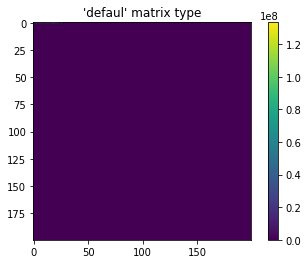

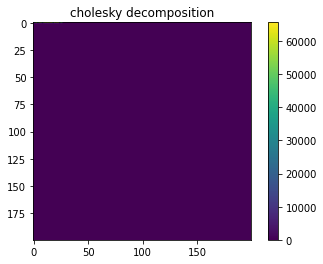

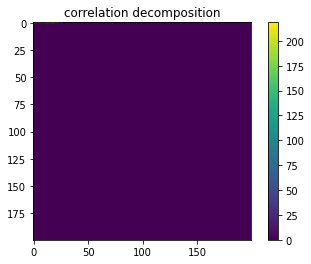

In [49]:
plt.imshow(L_vanilla)
plt.title("'defaul' matrix type")
cbar = plt.colorbar()

plt.figure()
plt.title("cholesky decomposition")
plt.imshow(L_cholesky)
cbar = plt.colorbar()

plt.figure()
plt.title("correlation decomposition")
plt.imshow(L_corr)
cbar = plt.colorbar()

In [50]:
mu_v, med_v = np.mean(L_vanilla), np.median(L_vanilla)
mu_l, med_l = np.mean(L_cholesky), np.median(L_cholesky)
mu_c, med_c = np.mean(L_corr), np.median(L_corr)
print("mean + var (log C)    = {:0.3f},  {:0.3f}".format(mu_v, med_v))
print("mean + var (cholesky) = {:0.3f},  {:0.3f}".format(mu_l, med_l))
print("mean + var (corr)     = {:0.3f},  {:0.3f}".format(mu_c, med_c))

mean + var (log C)    = 53307.431,  0.000
mean + var (cholesky) = 33.181,  0.000
mean + var (corr)     = 0.104,  0.000


In [56]:
# Signal to noise is calculated using equation 8 in Wadeckar et al 2020
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

(0.0, 1.0, 0.0, 1.0)

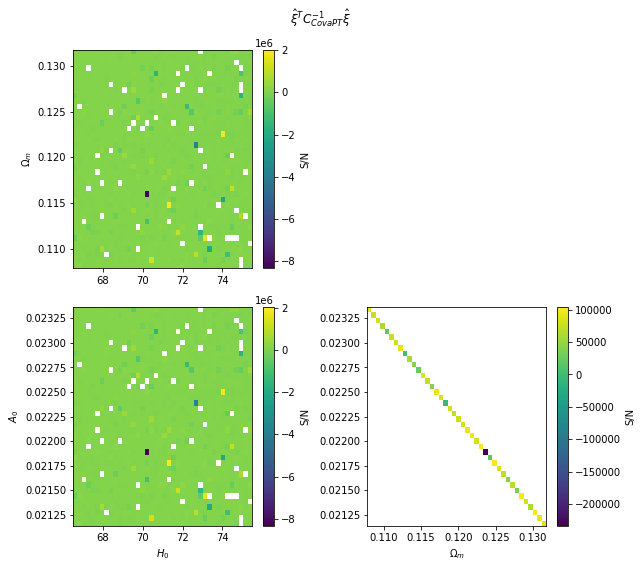

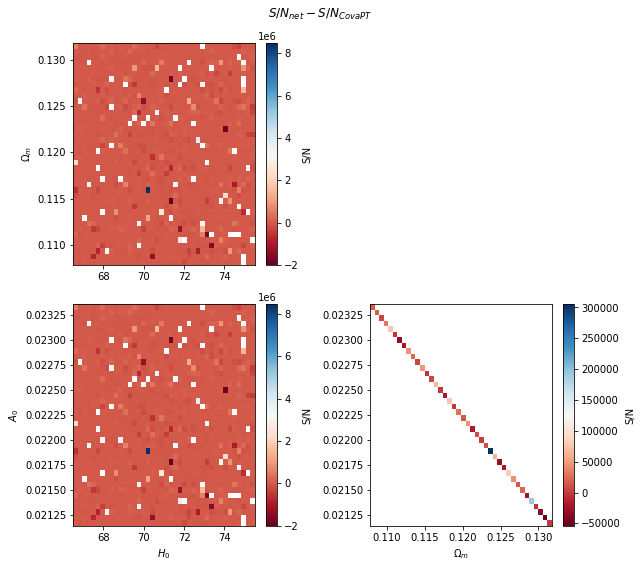

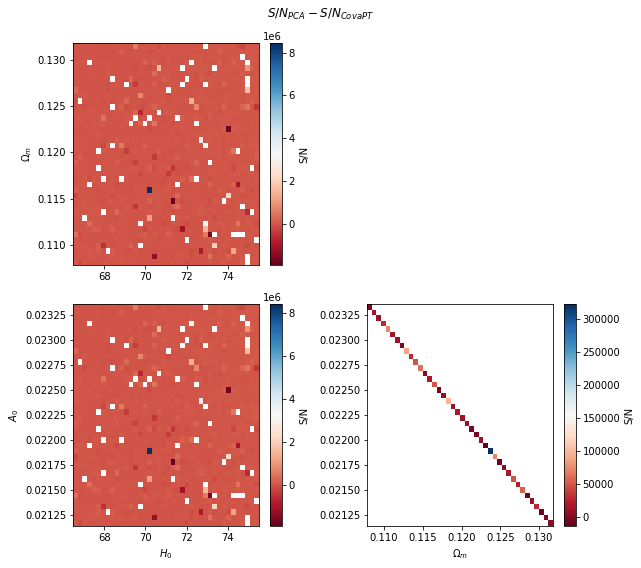

In [57]:
params = test_data[:][0].cpu().detach().numpy()
H0 = params[:,0]; omch2 = params[:,1]; As = params[:,3]

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$\hat{\xi}^T C_{CovaPT}^{-1} \hat{\xi}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_true, 40)
m = axs[0,0].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_true, 40)
m = axs[1,0].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_true, 40)
m = axs[1,1].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$S/N_{net} - S/N_{CovaPT}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_diff_vanilla, 40)
m = axs[0,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_diff_vanilla, 40)
m = axs[1,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_diff_vanilla, 40)
m = axs[1,1].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$S/N_{PCA} - S/N_{CovaPT}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_diff_PCA, 40)
m = axs[0,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_diff_PCA, 40)
m = axs[1,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_diff_PCA, 40)
m = axs[1,1].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

In [ ]:
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
latent = net_cholesky(params);    C_cholesky = decoder_cholesky(latent.view(1,10)).view(100, 100)
#C_cholesky = symmetric_log(torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))).cpu().detach().numpy()
C_cholesky = C_cholesky.cpu().detach().numpy()
plt.imshow(C_cholesky, cmap="RdBu")